In [1]:
!pip install tqdm --quiet

import requests
import pandas as pd
import numpy as np
import ast
import json
import time
from tqdm import tqdm

BASE_URL = "https://api.opendota.com/api/explorer"
VERSION = 21
LIMIT = 50000
BATCH_SIZE = 500
SLEEP_TIME = 1.0

print("Ready. BASE_URL =", BASE_URL)


Ready. BASE_URL = https://api.opendota.com/api/explorer


In [2]:
!pip install tqdm --quiet
import requests
import pandas as pd
import numpy as np
import ast
import json
import time
from tqdm import tqdm


def fetch_matches_paginated(version=VERSION, total_needed=LIMIT, page_size=5000, sleep_time=SLEEP_TIME):
    all_matches = []
    current_count = 0
    last_max_id = None

    print(f"Fetching ~{total_needed} matches from version = {version} ...")

    while current_count < total_needed:
        where_clause = f"m.version = {version} AND m.radiant_win IS NOT NULL AND m.duration > 0"

        if last_max_id is not None:
            where_clause += f" AND m.match_id < {last_max_id}"

        sql = f"""
        SELECT
            m.match_id, m.start_time, m.duration,
            CAST(m.radiant_win AS int) AS radiant_win,
            m.radiant_score, m.dire_score,
            m.radiant_gold_adv, m.radiant_xp_adv,
            m.tower_status_radiant, m.tower_status_dire,
            m.barracks_status_radiant, m.barracks_status_dire,
            m.objectives, m.teamfights, m.version
        FROM matches m
        WHERE {where_clause}
        ORDER BY m.match_id DESC
        LIMIT {page_size};
        """

        try:
            resp = requests.get(BASE_URL, params={"sql": sql})
            if resp.status_code != 200:
                print(f"Error: {resp.status_code}")
                time.sleep(3)
                continue

            rows = resp.json().get("rows", [])
            if not rows:
                print("No more rows returned.")
                break

            df_page = pd.DataFrame(rows)
            all_matches.append(df_page)

            count_in_page = len(df_page)
            current_count += count_in_page
            last_max_id = df_page["match_id"].min()

            print(f"Fetched {count_in_page} rows. Total: {current_count}/{total_needed}. Next ID < {last_max_id}")
            time.sleep(sleep_time)

        except Exception as e:
            print(f"Exception: {e}")
            time.sleep(3)
            continue

    df_final = pd.concat(all_matches, ignore_index=True)
    df_final = df_final.drop_duplicates(subset=["match_id"])
    df_final = df_final.head(total_needed)

    print("Final match count:", df_final.shape)
    return df_final

df_matches = fetch_matches_paginated()
df_matches.to_csv("matches.csv", index=False)

Fetching ~50000 CLEAN matches (no NaNs) from version = 21 ...
Fetched 5000 rows. Total: 5000/50000. Next ID < 8095741297
Fetched 5000 rows. Total: 10000/50000. Next ID < 7997543937
Fetched 5000 rows. Total: 15000/50000. Next ID < 7904058083
Fetched 5000 rows. Total: 20000/50000. Next ID < 7802336818
Fetched 5000 rows. Total: 25000/50000. Next ID < 7686968352
Fetched 5000 rows. Total: 30000/50000. Next ID < 7595486096
Fetched 5000 rows. Total: 35000/50000. Next ID < 7503338739
Fetched 5000 rows. Total: 40000/50000. Next ID < 7400158899
Fetched 5000 rows. Total: 45000/50000. Next ID < 7294786050
Fetched 5000 rows. Total: 50000/50000. Next ID < 7210622309
Final match count: (50000, 15)


In [4]:
def fetch_player_matches(match_ids, batch_size=BATCH_SIZE):
    all_batches = []
    chunks = range(0, len(match_ids), batch_size)

    print(f"Fetching players for {len(match_ids)} matches in {len(chunks)} batches...")

    for i in tqdm(chunks, desc="Fetching batches"):
        batch = match_ids[i : i + batch_size]
        ids_str = ",".join(map(str, batch))

        sql = f"""
        SELECT
            pm.match_id, pm.account_id, pm.player_slot, pm.hero_id,
            pm.kills, pm.deaths, pm.assists, pm.last_hits,
            pm.gold_per_min, pm.xp_per_min, pm.kills_log,
            pm.lh_t, pm.dn_t
        FROM player_matches pm
        WHERE pm.match_id IN ({ids_str})
        LIMIT 6000;
        """

        try:
            resp = requests.get(BASE_URL, params={"sql": sql})
            if resp.status_code != 200:
                print(f"Batch {i} failed ({resp.status_code}). Retrying...")
                time.sleep(3)
                continue

            rows = resp.json().get("rows", [])

            if len(rows) >= 6000:
                print(f"WARNING: Batch {i} hit the 6000 limit")

            if rows:
                all_batches.append(pd.DataFrame(rows))

            time.sleep(1.5)

        except Exception as e:
            print(f"Exception at batch {i}: {e}")
            time.sleep(2)

    if not all_batches:
        return pd.DataFrame()

    df_pm = pd.concat(all_batches, ignore_index=True)
    print("Player matches fetched:", df_pm.shape)
    return df_pm

match_ids = df_matches['match_id'].tolist()
df_pm = fetch_player_matches(match_ids)
df_pm.to_csv("player_matches.csv", index=False)


Fetching players for 50000 matches in 100 batches...


Fetching batches: 100%|██████████| 100/100 [08:44<00:00,  5.25s/it]


Player matches fetched: (500000, 13)
Avg players per match: 10.00


In [5]:
player_counts = df_pm.groupby('match_id').size()

perfect_matches = player_counts[player_counts == 10]
incomplete_matches = player_counts[player_counts < 10]
overfilled_matches = player_counts[player_counts > 10]

println("diagnostics")
println(f"Total unique matches in df_pm: {len(player_counts)}")
println(f"Matches with exactly 10 players: {len(perfect_matches)}")
println(f"Matches with < 10 players:       {len(incomplete_matches)}")
println(f"Matches with > 10 players:       {len(overfilled_matches)}")

if len(incomplete_matches) > 0:
    println(incomplete_matches.value_counts().sort_index())

    println("List of Incomplete Match IDs (First 20) ---")
    println(incomplete_matches.head(20).index.tolist())
else:
    println("All matches are perfect.")

=== DIAGNOSTIC REPORT ===
Total unique matches in df_pm: 50000
Matches with exactly 10 players: 50000
Matches with < 10 players:       0
Matches with > 10 players:       0

--- Distribution of Incomplete Matches ---
None! All matches are perfect.


In [28]:
import pandas as pd
import os

print("Reloading data from CSVs...")

# 1. Load Matches
if os.path.exists("matches.csv"):
    print("Found 'matches.csv'. Loading...")
    df_matches = pd.read_csv("matches.csv")
else:
    print("Error: No matches CSV found. You might need to re-run Block 1.")

# 2. Load Player Matches
req_player_cols = [
    'match_id', 'player_slot', 'hero_id',
    'kills_log', 'lh_t', 'dn_t',
    'assists', 'last_hits', 'kills', 'deaths'
]

path_pm = "player_matches.csv"

if os.path.exists(path_pm):
    print(f"Found '{path_pm}'. Loading...")

    header = pd.read_csv(path_pm, nrows=0).columns.tolist()
    use_cols = [c for c in req_player_cols if c in header]

    df_pm = pd.read_csv(path_pm, usecols=use_cols)
    print(f"Loaded df_matches: {df_matches.shape}")
    print(f"Loaded df_pm: {df_pm.shape}")
else:
    print("Error: No player_matches CSV found.")

Reloading data from CSVs...
Found 'matches.csv'. Loading...
Found 'player_matches.csv'. Loading...
Loaded df_matches: (50000, 15)
Loaded df_pm: (500000, 10)


In [31]:
#Hero composition and One-Hot Encoding
import pandas as pd
import json
import requests
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer

try:
    with open("heroes.json", "r") as f:
        heroes_data = json.load(f)
    hero_id_to_name = {int(k): heroes_data[k]['localized_name'] for k in heroes_data}
    use_names = True
    print("Loaded heroes.json")
except:
    try:
        print("Fetching heroes from API...")
        h_resp = requests.get("https://api.opendota.com/api/heroes")
        heroes_list = h_resp.json()
        heroes_data = {str(h['id']): h for h in heroes_list}
        hero_id_to_name = {int(k): heroes_data[k]['localized_name'] for k in heroes_data}
        use_names = True
        print("Success! Heroes loaded.")
    except:
        print("Could not load heroes. Using IDs.")
        hero_id_to_name = {}
        use_names = False

def build_team_heroes(df_player_matches):
    print("Grouping players...")
    grouped = df_player_matches.groupby('match_id')
    recs = []
    for mid, g in tqdm(grouped, desc="Grouping"):
        radiant_ids = g[g['player_slot'] < 128]['hero_id'].tolist()
        dire_ids = g[g['player_slot'] >= 128]['hero_id'].tolist()

        if use_names:
            radiant = [hero_id_to_name.get(int(h), str(h)).replace(" ", "_") for h in radiant_ids]
            dire = [hero_id_to_name.get(int(h), str(h)).replace(" ", "_") for h in dire_ids]
        else:
            radiant = [int(h) for h in radiant_ids]
            dire = [int(h) for h in dire_ids]

        recs.append({'match_id': mid, 'radiant_heroes': radiant, 'dire_heroes': dire})
    return pd.DataFrame(recs)

df_hero_comp = build_team_heroes(df_pm)

df = df_matches.merge(df_hero_comp, on='match_id', how='left')

print("Generating One-Hot columns (Union Fit)...")
mlb = MultiLabelBinarizer()

all_heroes = df['radiant_heroes'].tolist() + df['dire_heroes'].tolist()
mlb.fit(all_heroes)

r_ohe = mlb.transform(df['radiant_heroes'])
d_ohe = mlb.transform(df['dire_heroes'])

r_cols = [f"r_{c}" for c in mlb.classes_]
d_cols = [f"d_{c}" for c in mlb.classes_]

df_r = pd.DataFrame(r_ohe, columns=r_cols, index=df.index)
df_d = pd.DataFrame(d_ohe, columns=d_cols, index=df.index)

df_final = pd.concat([df, df_r, df_d], axis=1)
print(f"Encoding complete. Shape: {df_final.shape}")

df_final.to_csv("dota2_cleaned_dataset.csv", index=False)
df_final.to_csv("dota2_cleaned_dataset_copy.csv", index=False)
print("Saved to dota2_cleaned_dataset.csv")

Fetching heroes from API...
Success! Heroes loaded.
Grouping players...


Grouping: 100%|██████████| 50000/50000 [00:39<00:00, 1262.19it/s]


Generating One-Hot columns (Union Fit)...
Encoding complete. Shape: (50000, 267)
Saved to dota2_cleaned_dataset.csv


In [3]:
#Optimized Feature Extraction
import json
import numpy as np
import ast
from tqdm import tqdm

WINDOWS = [10, 20, 30]

def safe_parse_list(val):
    if isinstance(val, list): return val
    if isinstance(val, str):
        try:
            return json.loads(val.replace("'", '"'))
        except:
            try:
                return ast.literal_eval(val)
            except:
                return []
    return []

def process_player_data_bulk(df_players, windows):
    match_stats = {}
    print(f"Processing player stats (Windows {windows} + Final)...")

    req_cols = ['match_id', 'player_slot', 'kills_log', 'lh_t', 'dn_t', 'assists', 'last_hits']
    actual_cols = [c for c in req_cols if c in df_players.columns]

    for idx, row in tqdm(df_players[actual_cols].iterrows(), total=len(df_players), desc="Parsing Players"):
        mid = row['match_id']
        slot = row['player_slot']
        is_radiant = slot < 128
        team_prefix = 'r' if is_radiant else 'd'

        if mid not in match_stats:
            match_stats[mid] = {}
            for w in windows:
                for t in ['r', 'd']:
                    match_stats[mid][f'{t}_kills_{w}'] = 0
                    match_stats[mid][f'{t}_lh_{w}'] = 0
                    match_stats[mid][f'{t}_dn_{w}'] = 0
            for t in ['r', 'd']:
                match_stats[mid][f'{t}_assists_final'] = 0
                match_stats[mid][f'{t}_lh_final'] = 0
                match_stats[mid][f'{t}_dn_final'] = 0

        kills_log = safe_parse_list(row.get('kills_log'))
        lh_t = safe_parse_list(row.get('lh_t'))
        dn_t = safe_parse_list(row.get('dn_t'))

        for w in windows:
            cutoff_sec = w * 60

            k_count = 0
            if kills_log:
                for k in kills_log:
                    t = k.get('time') if isinstance(k, dict) else k
                    try:
                        if int(t) <= cutoff_sec: k_count += 1
                    except: pass
            match_stats[mid][f'{team_prefix}_kills_{w}'] += k_count

            if lh_t:
                idx = min(len(lh_t) - 1, w)
                match_stats[mid][f'{team_prefix}_lh_{w}'] += lh_t[idx]
            if dn_t:
                idx = min(len(dn_t) - 1, w)
                match_stats[mid][f'{team_prefix}_dn_{w}'] += dn_t[idx]

        match_stats[mid][f'{team_prefix}_assists_final'] += int(row.get('assists', 0))

        if 'last_hits' in row:
            match_stats[mid][f'{team_prefix}_lh_final'] += int(row.get('last_hits', 0))
        elif lh_t:
            match_stats[mid][f'{team_prefix}_lh_final'] += lh_t[-1]

        if dn_t:
            match_stats[mid][f'{team_prefix}_dn_final'] += dn_t[-1]

    return match_stats

player_stats_lookup = process_player_data_bulk(df_pm, WINDOWS)
print("Player stats aggregation complete.")

Processing player stats (Windows [10, 20, 30] + Final)...


Parsing Players: 100%|██████████| 500000/500000 [01:02<00:00, 7997.21it/s]

Player stats aggregation complete.


In [5]:
#Master Dataset Assembly
import pandas as pd
import numpy as np
import json
import ast
from tqdm import tqdm

def safe_int(val):
    try: return 0 if pd.isna(val) else int(val)
    except: return 0

def safe_parse_list(val):
    if isinstance(val, list): return val
    if isinstance(val, str):
        try: return json.loads(val.replace("'", '"'))
        except:
            try: return ast.literal_eval(val)
            except: return []
    return []

def parse_objectives(obj_list, cutoff):
    r_tow = d_tow = r_rax = d_rax = r_rosh = d_rosh = 0
    if not obj_list: return 0,0,0,0,0,0

    for obj in obj_list:
        if not isinstance(obj, dict): continue
        if obj.get('time', 99999) > cutoff: continue

        key = str(obj.get('key', ''))
        typ = obj.get('type', '')
        team = obj.get('team')
        slot = obj.get('player_slot')

        if typ == 'building_kill' and 'tower' in key:
            if 'badguys' in key: r_tow += 1
            if 'goodguys' in key: d_tow += 1

        if 'rax' in key:
            if 'badguys' in key: r_rax += 1
            if 'goodguys' in key: d_rax += 1

        if typ == 'roshan_kill':
            is_radiant = False
            if team == 2: is_radiant = True
            elif team == 3: is_radiant = False
            elif slot is not None: is_radiant = (slot < 128)

            if is_radiant: r_rosh += 1
            else: d_rosh += 1

    return r_tow, d_tow, r_rax, d_rax, r_rosh, d_rosh

def parse_teamfights_window(tf_list, cutoff):
    count = 0
    r_wins = 0
    d_wins = 0
    if not tf_list: return 0, 0, 0

    for tf in tf_list:
        if not isinstance(tf, dict): continue
        if tf.get('start', 99999) > cutoff: continue
        count += 1

        r_deaths = 0
        d_deaths = 0
        players = tf.get('players', [])
        if isinstance(players, list):
            for i, p in enumerate(players):
                if not isinstance(p, dict): continue
                deaths = p.get('deaths', 0)
                slot = p.get('player_slot')
                is_radiant = (slot < 128) if slot is not None else (i < 5)
                if is_radiant: r_deaths += deaths
                else: d_deaths += deaths

        if r_deaths < d_deaths: r_wins += 1
        elif d_deaths < r_deaths: d_wins += 1

    return count, r_wins, d_wins

out_rows = []
minutes = [10, 20, 30]

print("Loading data from dota2_cleaned_dataset.csv...")
df_source = pd.read_csv("dota2_cleaned_dataset.csv")
print(f"Loaded. Shape: {df_source.shape}")

print("Assembling Master Dataset...")

for idx, row in tqdm(df_source.iterrows(), total=len(df_source), desc="Merging"):
    mid = row['match_id']

    radiant_score = safe_int(row.get('radiant_score'))
    dire_score = safe_int(row.get('dire_score'))

    mrec = {
        'match_id': mid,
        'start_time': row.get('start_time'),
        'duration': row.get('duration'),
        'radiant_win': safe_int(row.get('radiant_win')),
        'radiant_score': radiant_score,
        'dire_score': dire_score,
        'r_kills_final': radiant_score,
        'd_kills_final': dire_score,
        'r_deaths_final': dire_score,
        'd_deaths_final': radiant_score,
    }

    gold_adv = safe_parse_list(row.get('radiant_gold_adv'))
    xp_adv = safe_parse_list(row.get('radiant_xp_adv'))
    objectives = safe_parse_list(row.get('objectives'))
    teamfights = safe_parse_list(row.get('teamfights'))

    for m in minutes:
        cutoff = m * 60
        mrec[f'gold_adv_{m}'] = gold_adv[min(len(gold_adv)-1, m)] if gold_adv else 0
        mrec[f'xp_adv_{m}']   = xp_adv[min(len(xp_adv)-1, m)] if xp_adv else 0

        r_t, d_t, r_r, d_r, r_ro, d_ro = parse_objectives(objectives, cutoff)
        mrec[f'r_towers_{m}'] = r_t
        mrec[f'd_towers_{m}'] = d_t
        mrec[f'r_rax_{m}']    = r_r
        mrec[f'd_rax_{m}']    = d_r
        mrec[f'r_roshan_{m}'] = r_ro
        mrec[f'd_roshan_{m}'] = d_ro

        tf_c, r_w, d_w = parse_teamfights_window(teamfights, cutoff)
        mrec[f'tf_count_{m}'] = tf_c
        mrec[f'r_tf_win_rate_{m}'] = (r_w / tf_c) if tf_c > 0 else 0.0
        mrec[f'd_tf_win_rate_{m}'] = (d_w / tf_c) if tf_c > 0 else 0.0

        stats = player_stats_lookup.get(mid, {})
        for stat in ['kills', 'lh', 'dn']:
            mrec[f'r_{stat}_{m}'] = stats.get(f'r_{stat}_{m}', 0)
            mrec[f'd_{stat}_{m}'] = stats.get(f'd_{stat}_{m}', 0)

    mrec['gold_adv_final'] = gold_adv[-1] if gold_adv else 0
    mrec['xp_adv_final']   = xp_adv[-1] if xp_adv else 0

    r_t, d_t, r_r, d_r, r_ro, d_ro = parse_objectives(objectives, 999999)
    mrec['r_towers_final'] = r_t
    mrec['d_towers_final'] = d_t
    mrec['r_rax_final']    = r_r
    mrec['d_rax_final']    = d_r
    mrec['r_roshan_final'] = r_ro
    mrec['d_roshan_final'] = d_ro

    tf_c, r_w, d_w = parse_teamfights_window(teamfights, 999999)
    mrec['tf_count_final'] = tf_c
    mrec['r_tf_win_rate_final'] = (r_w / tf_c) if tf_c > 0 else 0.0
    mrec['d_tf_win_rate_final'] = (d_w / tf_c) if tf_c > 0 else 0.0

    stats = player_stats_lookup.get(mid, {})
    for team in ['r', 'd']:
        for stat in ['assists', 'lh', 'dn']:
            mrec[f'{team}_{stat}_final'] = stats.get(f'{team}_{stat}_final', 0)

    hero_cols = [c for c in df_source.columns if c.startswith('r_') or c.startswith('d_')]
    for hc in hero_cols:
        if hc not in mrec:
            mrec[hc] = row.get(hc, 0)

    out_rows.append(mrec)

df_final = pd.DataFrame(out_rows)
df_final = df_final.dropna(subset=['radiant_win'])
print("Final Dataset Shape:", df_final.shape)
df_final.to_csv("dota2_master_dataset.csv", index=False)
print("Saved: dota2_master_dataset.csv")

Loading data from Block 3 (dota2_master_dataset_v2.csv)...
Loaded. Shape: (50000, 267)
Assembling Master Dataset...


Merging: 100%|██████████| 50000/50000 [01:40<00:00, 497.43it/s]


Final Dataset Shape: (50000, 328)
Saved: dota2_master_dataset.csv


Loading dataset...
Data Loaded. Shape: (50000, 328)


/tmp/ipython-input-3267135962.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='radiant_win', data=df, palette='coolwarm')


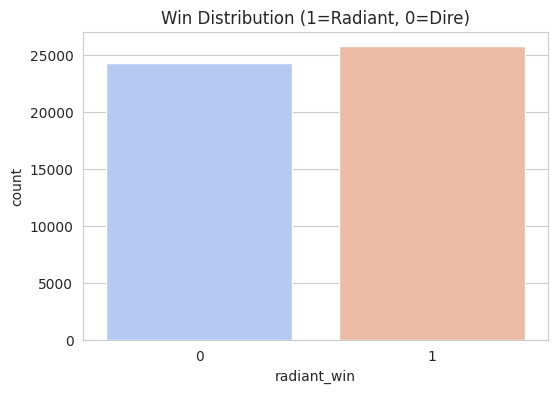

Radiant Win Rate: 51.46%


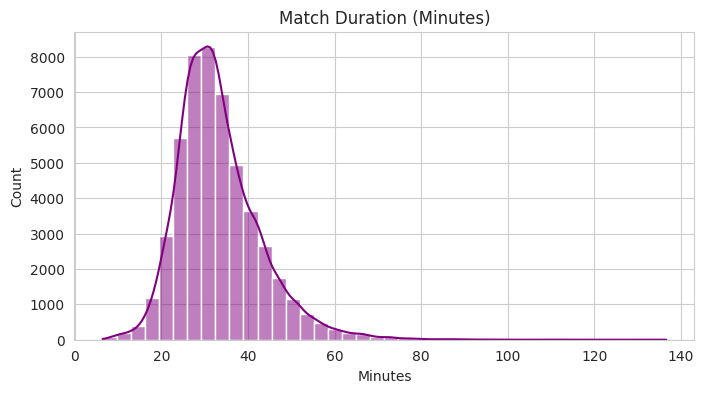

Calculating correlations...


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipython-input-3267135962.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette=colors)


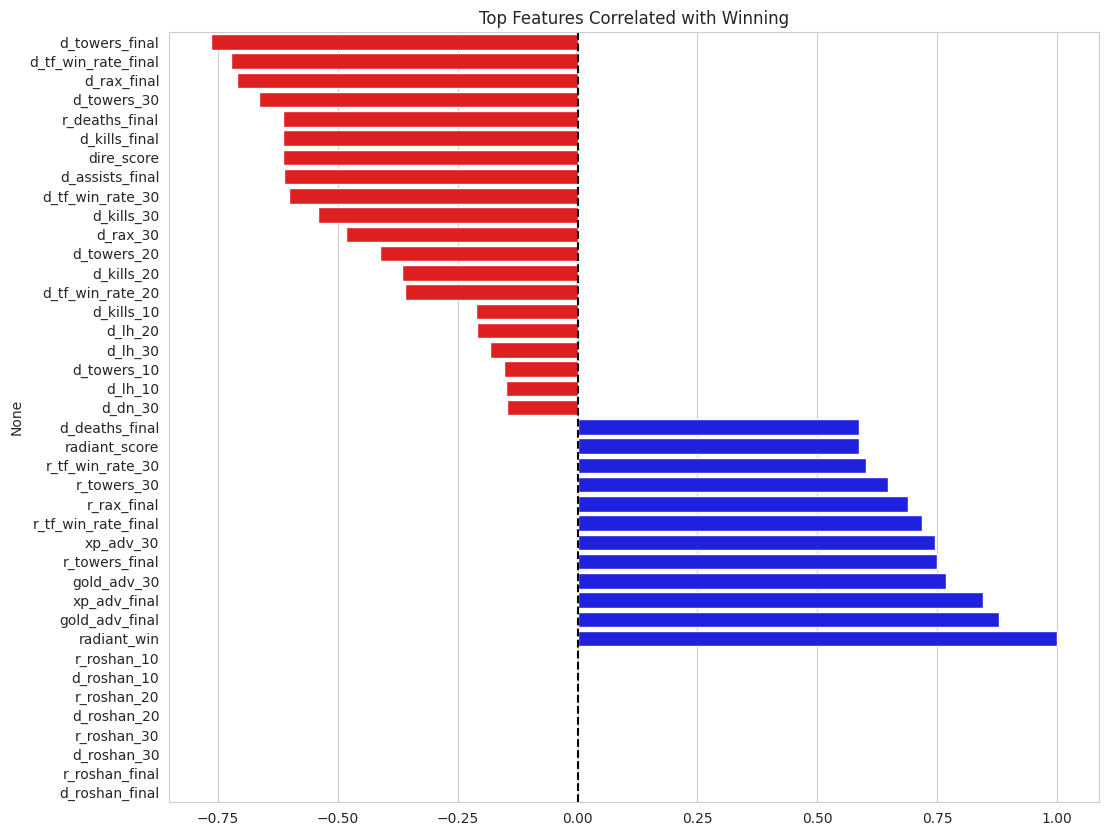

Running PCA...


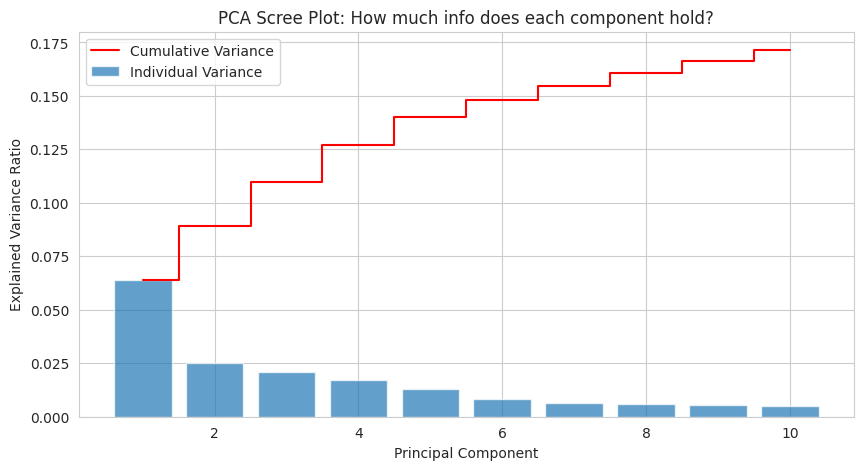

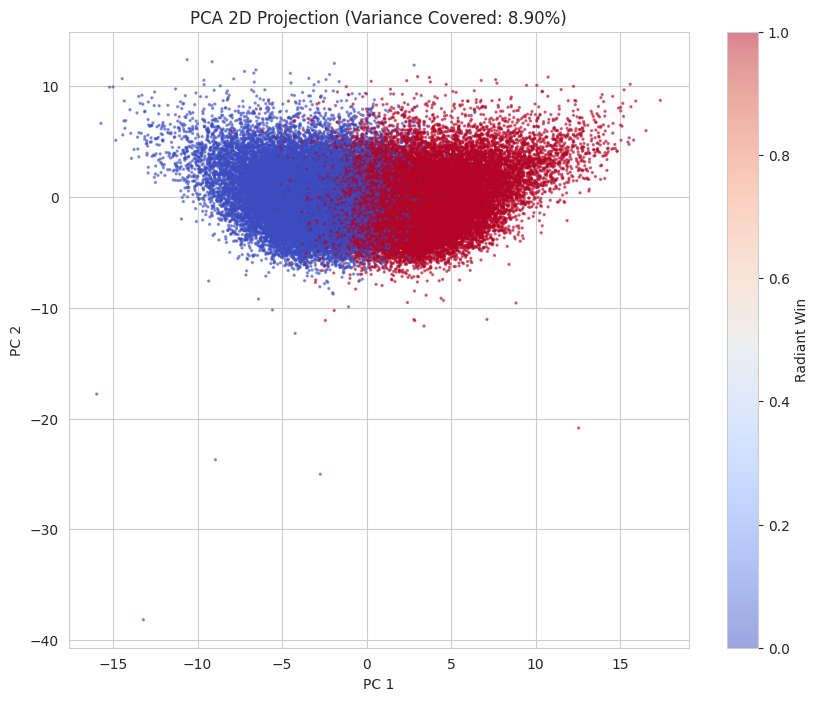

In [13]:
#EDA
!pip install shap xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_style("whitegrid")

print("Loading dataset...")
df = pd.read_csv('dota2_master_dataset.csv')
print(f"Data Loaded. Shape: {df.shape}")

plt.figure(figsize=(6, 4))
sns.countplot(x='radiant_win', data=df, palette='coolwarm')
plt.title('Win Distribution (1=Radiant, 0=Dire)')
plt.show()
print(f"Radiant Win Rate: {df['radiant_win'].mean():.2%}")

plt.figure(figsize=(8, 4))
sns.histplot(df['duration'] / 60, bins=40, kde=True, color='purple')
plt.title('Match Duration (Minutes)')
plt.xlabel('Minutes')
plt.show()

print("Calculating correlations...")
corrs = df.corrwith(df['radiant_win']).sort_values()
top_neg = corrs.head(20)
top_pos = corrs.iloc[:-1].tail(20) # Exclude target itself
top_corr = pd.concat([top_neg, top_pos])

plt.figure(figsize=(12, 10))
colors = ['red' if x < 0 else 'blue' for x in top_corr.values]
sns.barplot(x=top_corr.values, y=top_corr.index, palette=colors)
plt.title('Top Features Correlated with Winning')
plt.axvline(0, color='black', linestyle='--')
plt.show()

print("Running PCA...")
drop_cols = ['match_id', 'start_time', 'radiant_win', 'radiant_score', 'dire_score']
X_pca = df.drop(columns=[c for c in drop_cols if c in df.columns]).fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca.select_dtypes(include=np.number))

pca_10 = PCA(n_components=10)
pca_10.fit(X_scaled)

plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), pca_10.explained_variance_ratio_, alpha=0.7, align='center')
plt.step(range(1, 11), np.cumsum(pca_10.explained_variance_ratio_), where='mid', color='red')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot: How much info does each component hold?')
plt.legend(['Cumulative Variance', 'Individual Variance'])
plt.show()

components = pca_10.transform(X_scaled)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(components[:, 0], components[:, 1], c=df['radiant_win'], cmap='coolwarm', alpha=0.5, s=2)
plt.colorbar(scatter, label='Radiant Win')
plt.title(f'PCA 2D Projection (Variance Covered: {np.sum(pca_10.explained_variance_ratio_[:2]):.2%})')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [1]:
#Training Helper
def train_model(X, y, name="Model"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )

    print(f"Training {name} (Features: {X.shape[1]})...")
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)

    print(f" -> Accuracy: {acc:.4f} | AUC: {auc:.4f}")
    return model, acc, auc

In [2]:
#Seed generation func
import random
import hashlib

def md5_hash(input_string):
  """Generates an MD5 hash from a given string.
  Args:
    input_string: The string to hash.
  Returns:
    The MD5 hash as a hexadecimal string.
  """
  md5_hasher = hashlib.md5()
  md5_hasher.update(input_string.encode('utf-8'))
  return md5_hasher.hexdigest()

input_string = "Pushpendra"
hashed_value = md5_hash(input_string)
print(f"The MD5 hash of '{input_string}' is: {hashed_value}")

try:
    number = int(hashed_value, 16)
    print(f"The integer representation of the hash is: {number}")
except ValueError:
    print("Invalid hexadecimal string")

random.seed(number)

print(f"Initial seed number: {number}")

random.seed(number)
a = 0
b = 2**31-1
random_numbers = [random.randint(a, b) for _ in range(10)]

print("Seed", random_numbers)

The MD5 hash of 'Pushpendra' is: 37890fc03c9583d3ab6982c2fa425170
The integer representation of the hash is: 73819203904490754979654330055460540784
Initial seed number: 73819203904490754979654330055460540784
Seed [365604478, 66987833, 2084502017, 430412094, 829768322, 859469583, 643230104, 903779310, 1873229203, 1190490405]


In [2]:
#Full Model Comparison (Economy vs Skirmish vs Objectives vs Draft)
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")

print("Loading V3 Dataset...")
df = pd.read_csv("dota2_master_dataset.csv")
print(f"Data Loaded: {df.shape}")

stat_keywords = ['kills', 'deaths', 'assists', 'lh', 'dn', 'towers', 'rax', 'roshan', 'tf_', 'gold', 'xp', 'win_rate', 'score', 'win']
hero_cols = [c for c in df.columns if (c.startswith('r_') or c.startswith('d_')) and not any(k in c for k in stat_keywords)]
print(f"Identified {len(hero_cols)} Hero Columns.")

def get_features_for_window(minute):
    """Returns a dictionary of feature groups for a specific time window (10, 20, 30, 'final')."""
    suffix = f"_{minute}"

    groups = {}

    # Group A: Economy (Gold, XP, Last Hits, Denies)
    groups["Economy"] = [
        f"gold_adv{suffix}", f"xp_adv{suffix}",
        f"r_lh{suffix}", f"d_lh{suffix}",
        f"r_dn{suffix}", f"d_dn{suffix}"
    ]

    # Group B: Skirmish (Kills, Deaths, Teamfight Win Rate)
    groups["Skirmish"] = [
        f"r_kills{suffix}", f"d_kills{suffix}",
        f"r_tf_win_rate{suffix}", f"d_tf_win_rate{suffix}",
        f"tf_count{suffix}"
    ]

    # Group C: Objectives (Towers, Rax, Roshan)
    groups["Objectives"] = [
        f"r_towers{suffix}", f"d_towers{suffix}",
        f"r_rax{suffix}", f"d_rax{suffix}",
        f"r_roshan{suffix}", f"d_roshan{suffix}"
    ]

    # Group D: Draft (Heroes only)
    groups["Draft"] = hero_cols

    # Group E: All (Everything combined)
    groups["All_Features"] = groups["Economy"] + groups["Skirmish"] + groups["Objectives"] + groups["Draft"]

    return groups

models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(n_estimators=100, eval_metric="logloss", use_label_encoder=False, n_jobs=-1),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
}

windows = [10, 20, 30, 'final']
seeds = [42, 7, 123]
results = []

print("\nStarting Experiments...")

for w in windows:
    feature_groups = get_features_for_window(w)

    for group_name, feats in feature_groups.items():
        valid_feats = [f for f in feats if f in df.columns]
        if not valid_feats:
            print(f"Skipping {group_name} at {w}: No valid columns found.")
            continue

        X = df[valid_feats].fillna(0)
        y = df['radiant_win']

        print(f"  [Window: {w}] Group: {group_name} ({len(valid_feats)} feats)...")

        for model_name, model in models.items():
            acc_scores = []

            for seed in seeds:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

                if model_name in ["LogReg", "SVM"]:
                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_test = scaler.transform(X_test)

                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                acc_scores.append(accuracy_score(y_test, preds))

            results.append({
                "Window": str(w),
                "FeatureGroup": group_name,
                "Model": model_name,
                "Accuracy": np.mean(acc_scores),
                "StdDev": np.std(acc_scores)
            })

results_df = pd.DataFrame(results)

summary = results_df.pivot_table(
    index=["Window", "FeatureGroup"],
    columns="Model",
    values="Accuracy"
)

print("\n=== Final Accuracy Summary ===")
print(summary)

summary.to_csv("model_comparison_results.csv")

Loading V3 Dataset...
Data Loaded: (50000, 328)
Identified 248 Hero Columns.

Starting Experiments...
  [Window: 10] Group: Economy (6 feats)...
  [Window: 10] Group: Skirmish (5 feats)...
  [Window: 10] Group: Objectives (6 feats)...
  [Window: 10] Group: Draft (248 feats)...
  [Window: 10] Group: All_Features (265 feats)...
  [Window: 20] Group: Economy (6 feats)...
  [Window: 20] Group: Skirmish (5 feats)...
  [Window: 20] Group: Objectives (6 feats)...
  [Window: 20] Group: Draft (248 feats)...
  [Window: 20] Group: All_Features (265 feats)...
  [Window: 30] Group: Economy (6 feats)...
  [Window: 30] Group: Skirmish (5 feats)...
  [Window: 30] Group: Objectives (6 feats)...
  [Window: 30] Group: Draft (248 feats)...
  [Window: 30] Group: All_Features (265 feats)...
  [Window: final] Group: Economy (6 feats)...
  [Window: final] Group: Skirmish (5 feats)...
  [Window: final] Group: Objectives (6 feats)...
  [Window: final] Group: Draft (248 feats)...
  [Window: final] Group: All_Fea

In [3]:
#Optuna + Multi-Seed Optimized XGBoost
!pip install optuna
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

print("=== Running Optuna-Optimized XGBoost Experiments ===\n")

seeds = [365604478, 66987833, 2084502017, 430412094, 829768322, 859469583, 643230104, 903779310, 1873229203, 1190490405]

def xgb_objective(trial, X, y, seeds):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 14),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "n_jobs": -1,
        "random_state": 42
    }

    accs = []
    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )
        model = XGBClassifier(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        accs.append(accuracy_score(y_test, preds))

    return np.mean(accs)


optuna_results = []

windows = [10, 20, 30, "final"]

for minute in windows:
    feature_groups = get_features_for_window(minute)

    for group_name, feats in feature_groups.items():

        print(f"--- [Window = {minute}] Feature Group = {group_name} ---")

        valid_feats = [f for f in feats if f in df.columns]
        if not valid_feats:
            print(f"[SKIP] No columns for {group_name} at {minute}")
            continue

        X = df[valid_feats].fillna(0)
        y = df["radiant_win"]

        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: xgb_objective(trial, X, y, seeds),
                       n_trials=30,
                       show_progress_bar=False)

        best_params = study.best_params
        best_acc = study.best_value

        optuna_results.append({
            "Window": minute,
            "FeatureGroup": group_name,
            "BestParams": best_params,
            "BestAccuracy": best_acc
        })

        print(f"Best Accuracy = {best_acc:.4f}")
        print(f"Best Params = {best_params}\n")

optuna_df = pd.DataFrame(optuna_results)
optuna_df.to_csv("optuna_xgboost_complete_results.csv", index=False)

print("\n=== Final Optuna Summary ===")
print(optuna_df)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.7 MB/s eta 0:00:00


[I 2025-11-23 21:15:06,242] A new study created in memory with name: no-name-7d846e90-ef66-4def-9126-b51781781b75


=== Running Optuna-Optimized XGBoost Experiments ===

--- [Window = 10] Feature Group = Economy ---


[I 2025-11-23 21:15:24,484] Trial 0 finished with value: 0.6332 and parameters: {'n_estimators': 484, 'max_depth': 8, 'learning_rate': 0.14794094001574995, 'subsample': 0.7574681389973442, 'colsample_bytree': 0.6966741293220949, 'gamma': 0.940893341739593, 'min_child_weight': 8}. Best is trial 0 with value: 0.6332.
[I 2025-11-23 21:15:43,963] Trial 1 finished with value: 0.64641 and parameters: {'n_estimators': 155, 'max_depth': 13, 'learning_rate': 0.05706668970099888, 'subsample': 0.8279701900083105, 'colsample_bytree': 0.7588289923652654, 'gamma': 0.45738454136446194, 'min_child_weight': 2}. Best is trial 1 with value: 0.64641.
[I 2025-11-23 21:15:49,457] Trial 2 finished with value: 0.64107 and parameters: {'n_estimators': 185, 'max_depth': 11, 'learning_rate': 0.23890141222729228, 'subsample': 0.7503501323140661, 'colsample_bytree': 0.6403204012699404, 'gamma': 1.6329292390688925, 'min_child_weight': 3}. Best is trial 1 with value: 0.64641.
[I 2025-11-23 21:15:58,662] Trial 3 fini

Best Accuracy = 0.6617
Best Params = {'n_estimators': 446, 'max_depth': 4, 'learning_rate': 0.038088670299924396, 'subsample': 0.8556185898256048, 'colsample_bytree': 0.7708448876934628, 'gamma': 1.7794386445468324, 'min_child_weight': 4}

--- [Window = 10] Feature Group = Skirmish ---


[I 2025-11-23 21:21:19,604] Trial 0 finished with value: 0.62918 and parameters: {'n_estimators': 491, 'max_depth': 4, 'learning_rate': 0.23510494291405806, 'subsample': 0.8093135265298753, 'colsample_bytree': 0.7648487233750494, 'gamma': 1.6120692693776228, 'min_child_weight': 9}. Best is trial 0 with value: 0.62918.
[I 2025-11-23 21:21:23,371] Trial 1 finished with value: 0.6292199999999999 and parameters: {'n_estimators': 249, 'max_depth': 9, 'learning_rate': 0.2933667718312331, 'subsample': 0.9714544704810131, 'colsample_bytree': 0.6099034203274997, 'gamma': 0.3971857717691831, 'min_child_weight': 9}. Best is trial 1 with value: 0.6292199999999999.
[I 2025-11-23 21:21:32,568] Trial 2 finished with value: 0.6291 and parameters: {'n_estimators': 301, 'max_depth': 10, 'learning_rate': 0.06193322385336056, 'subsample': 0.9687084848754872, 'colsample_bytree': 0.5613764364279334, 'gamma': 0.12288454632612211, 'min_child_weight': 9}. Best is trial 1 with value: 0.6292199999999999.
[I 2025

Best Accuracy = 0.6301
Best Params = {'n_estimators': 327, 'max_depth': 8, 'learning_rate': 0.08279673914495912, 'subsample': 0.7356111596922196, 'colsample_bytree': 0.5326216382840118, 'gamma': 1.3898532396906695, 'min_child_weight': 7}

--- [Window = 10] Feature Group = Objectives ---


[I 2025-11-23 21:24:21,580] Trial 0 finished with value: 0.5689599999999999 and parameters: {'n_estimators': 178, 'max_depth': 3, 'learning_rate': 0.026348269203759316, 'subsample': 0.9801085317922857, 'colsample_bytree': 0.9185728167185561, 'gamma': 0.06164219947439431, 'min_child_weight': 5}. Best is trial 0 with value: 0.5689599999999999.
[I 2025-11-23 21:24:29,081] Trial 1 finished with value: 0.56731 and parameters: {'n_estimators': 377, 'max_depth': 7, 'learning_rate': 0.19222079296768507, 'subsample': 0.6226903227049263, 'colsample_bytree': 0.8075187604607275, 'gamma': 0.7615537891789479, 'min_child_weight': 7}. Best is trial 0 with value: 0.5689599999999999.
[I 2025-11-23 21:24:31,871] Trial 2 finished with value: 0.5680499999999999 and parameters: {'n_estimators': 162, 'max_depth': 4, 'learning_rate': 0.1228156358220784, 'subsample': 0.618810080181934, 'colsample_bytree': 0.8680220307815956, 'gamma': 1.2606453357769913, 'min_child_weight': 2}. Best is trial 0 with value: 0.568

Best Accuracy = 0.5690
Best Params = {'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.06854409189159266, 'subsample': 0.9400790662554436, 'colsample_bytree': 0.639206772576612, 'gamma': 0.30261449870539847, 'min_child_weight': 6}

--- [Window = 10] Feature Group = Draft ---


[I 2025-11-23 21:27:58,656] Trial 0 finished with value: 0.5289100000000001 and parameters: {'n_estimators': 334, 'max_depth': 12, 'learning_rate': 0.13178615748641836, 'subsample': 0.8130152480165953, 'colsample_bytree': 0.6722879688743235, 'gamma': 0.3749241813309889, 'min_child_weight': 3}. Best is trial 0 with value: 0.5289100000000001.
[I 2025-11-23 21:28:58,370] Trial 1 finished with value: 0.53646 and parameters: {'n_estimators': 448, 'max_depth': 4, 'learning_rate': 0.2938804380491142, 'subsample': 0.889060715500607, 'colsample_bytree': 0.8738551075797313, 'gamma': 1.6795134190359828, 'min_child_weight': 6}. Best is trial 1 with value: 0.53646.
[I 2025-11-23 21:29:30,590] Trial 2 finished with value: 0.53795 and parameters: {'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.17688246492025483, 'subsample': 0.8442270135106622, 'colsample_bytree': 0.6077023565997111, 'gamma': 1.4760268678350588, 'min_child_weight': 4}. Best is trial 2 with value: 0.53795.
[I 2025-11-23 21:30

Best Accuracy = 0.5411
Best Params = {'n_estimators': 464, 'max_depth': 7, 'learning_rate': 0.043575363172617454, 'subsample': 0.690677485452651, 'colsample_bytree': 0.7981549075968408, 'gamma': 1.9640333114159405, 'min_child_weight': 9}

--- [Window = 10] Feature Group = All_Features ---


[I 2025-11-23 21:58:27,489] Trial 0 finished with value: 0.6473 and parameters: {'n_estimators': 343, 'max_depth': 11, 'learning_rate': 0.1352219951363449, 'subsample': 0.8417147479566751, 'colsample_bytree': 0.729726203678633, 'gamma': 0.7257995136397841, 'min_child_weight': 6}. Best is trial 0 with value: 0.6473.
[I 2025-11-23 22:00:10,477] Trial 1 finished with value: 0.6501800000000001 and parameters: {'n_estimators': 424, 'max_depth': 14, 'learning_rate': 0.1091709032164793, 'subsample': 0.6866052084181924, 'colsample_bytree': 0.8528465828476393, 'gamma': 1.873586363408162, 'min_child_weight': 3}. Best is trial 1 with value: 0.6501800000000001.
[I 2025-11-23 22:01:40,236] Trial 2 finished with value: 0.64198 and parameters: {'n_estimators': 449, 'max_depth': 6, 'learning_rate': 0.27640387719364007, 'subsample': 0.9529879409182462, 'colsample_bytree': 0.5387389680867979, 'gamma': 0.19116747687208568, 'min_child_weight': 6}. Best is trial 1 with value: 0.6501800000000001.
[I 2025-11

Best Accuracy = 0.6680
Best Params = {'n_estimators': 366, 'max_depth': 4, 'learning_rate': 0.05168611935239122, 'subsample': 0.8430539989842067, 'colsample_bytree': 0.8227132906994243, 'gamma': 1.1807200226063908, 'min_child_weight': 2}

--- [Window = 20] Feature Group = Economy ---


[I 2025-11-23 22:33:21,448] Trial 0 finished with value: 0.72778 and parameters: {'n_estimators': 358, 'max_depth': 13, 'learning_rate': 0.20459101437651378, 'subsample': 0.9323639687008213, 'colsample_bytree': 0.6566962762709786, 'gamma': 0.4596864191111365, 'min_child_weight': 1}. Best is trial 0 with value: 0.72778.
[I 2025-11-23 22:33:37,699] Trial 1 finished with value: 0.7360599999999999 and parameters: {'n_estimators': 206, 'max_depth': 13, 'learning_rate': 0.07109120438250721, 'subsample': 0.784811291179508, 'colsample_bytree': 0.5998080689685025, 'gamma': 0.10228372881738901, 'min_child_weight': 10}. Best is trial 1 with value: 0.7360599999999999.
[I 2025-11-23 22:33:54,481] Trial 2 finished with value: 0.72446 and parameters: {'n_estimators': 348, 'max_depth': 10, 'learning_rate': 0.19479310289149762, 'subsample': 0.6149461354559015, 'colsample_bytree': 0.8189799271664759, 'gamma': 1.6210862850712109, 'min_child_weight': 7}. Best is trial 1 with value: 0.7360599999999999.
[I 

Best Accuracy = 0.7481
Best Params = {'n_estimators': 294, 'max_depth': 4, 'learning_rate': 0.03503360105736116, 'subsample': 0.7302116754602634, 'colsample_bytree': 0.8489585308610351, 'gamma': 0.9291669939574841, 'min_child_weight': 4}

--- [Window = 20] Feature Group = Skirmish ---


[I 2025-11-23 22:39:14,367] Trial 0 finished with value: 0.7057899999999999 and parameters: {'n_estimators': 257, 'max_depth': 10, 'learning_rate': 0.15892324141953493, 'subsample': 0.6195735648514725, 'colsample_bytree': 0.8723352505360666, 'gamma': 1.1575987306373692, 'min_child_weight': 5}. Best is trial 0 with value: 0.7057899999999999.
[I 2025-11-23 22:39:18,569] Trial 1 finished with value: 0.7117500000000001 and parameters: {'n_estimators': 282, 'max_depth': 13, 'learning_rate': 0.2844566787813662, 'subsample': 0.98752812752838, 'colsample_bytree': 0.5354259528437321, 'gamma': 1.195804193971989, 'min_child_weight': 1}. Best is trial 1 with value: 0.7117500000000001.
[I 2025-11-23 22:39:33,272] Trial 2 finished with value: 0.70502 and parameters: {'n_estimators': 485, 'max_depth': 14, 'learning_rate': 0.21297645883009253, 'subsample': 0.6941874619807409, 'colsample_bytree': 0.5927946402803577, 'gamma': 0.5612044612385516, 'min_child_weight': 3}. Best is trial 1 with value: 0.7117

Best Accuracy = 0.7144
Best Params = {'n_estimators': 424, 'max_depth': 3, 'learning_rate': 0.06540624159113545, 'subsample': 0.8945501709679183, 'colsample_bytree': 0.8149284778064917, 'gamma': 1.911638936380447, 'min_child_weight': 8}

--- [Window = 20] Feature Group = Objectives ---


[I 2025-11-23 22:43:46,230] Trial 0 finished with value: 0.69438 and parameters: {'n_estimators': 365, 'max_depth': 6, 'learning_rate': 0.21090274780816978, 'subsample': 0.6110694317291512, 'colsample_bytree': 0.8909049524784256, 'gamma': 0.8970998971052557, 'min_child_weight': 6}. Best is trial 0 with value: 0.69438.
[I 2025-11-23 22:43:49,294] Trial 1 finished with value: 0.69446 and parameters: {'n_estimators': 199, 'max_depth': 3, 'learning_rate': 0.16556991514756822, 'subsample': 0.8915292986224399, 'colsample_bytree': 0.9695169307392117, 'gamma': 1.051592693100969, 'min_child_weight': 9}. Best is trial 1 with value: 0.69446.
[I 2025-11-23 22:43:54,154] Trial 2 finished with value: 0.69458 and parameters: {'n_estimators': 189, 'max_depth': 12, 'learning_rate': 0.19771474256304822, 'subsample': 0.9369781996684036, 'colsample_bytree': 0.7486618673411947, 'gamma': 1.8508350328825574, 'min_child_weight': 10}. Best is trial 2 with value: 0.69458.
[I 2025-11-23 22:43:57,976] Trial 3 fin

Best Accuracy = 0.6946
Best Params = {'n_estimators': 238, 'max_depth': 13, 'learning_rate': 0.09105984262165533, 'subsample': 0.7482952555144212, 'colsample_bytree': 0.8019237386051115, 'gamma': 1.3673730194449325, 'min_child_weight': 6}

--- [Window = 20] Feature Group = Draft ---


[I 2025-11-23 22:46:47,273] A new study created in memory with name: no-name-cd2ee6c7-fadd-448a-9df2-c6ad54680e02
[I 2025-11-23 22:47:46,264] Trial 0 finished with value: 0.5320699999999999 and parameters: {'n_estimators': 217, 'max_depth': 14, 'learning_rate': 0.0809966181685953, 'subsample': 0.9709168843479284, 'colsample_bytree': 0.9368868368123731, 'gamma': 0.07381852951814682, 'min_child_weight': 7}. Best is trial 0 with value: 0.5320699999999999.
[I 2025-11-23 22:48:15,479] Trial 1 finished with value: 0.53271 and parameters: {'n_estimators': 156, 'max_depth': 5, 'learning_rate': 0.03560398588201161, 'subsample': 0.9084170850428752, 'colsample_bytree': 0.9478742920863032, 'gamma': 0.6252118309449524, 'min_child_weight': 8}. Best is trial 1 with value: 0.53271.
[I 2025-11-23 22:48:57,387] Trial 2 finished with value: 0.5354099999999999 and parameters: {'n_estimators': 194, 'max_depth': 9, 'learning_rate': 0.06086528412818096, 'subsample': 0.9551975758578238, 'colsample_bytree': 0.

Best Accuracy = 0.5415
Best Params = {'n_estimators': 348, 'max_depth': 4, 'learning_rate': 0.08530791684304748, 'subsample': 0.6490402775802603, 'colsample_bytree': 0.6273538817826452, 'gamma': 0.3937217080848626, 'min_child_weight': 10}

--- [Window = 20] Feature Group = All_Features ---


[I 2025-11-23 23:16:08,668] Trial 0 finished with value: 0.73659 and parameters: {'n_estimators': 255, 'max_depth': 14, 'learning_rate': 0.27754387080873294, 'subsample': 0.9523641359360774, 'colsample_bytree': 0.530291762454007, 'gamma': 1.5920133719500154, 'min_child_weight': 8}. Best is trial 0 with value: 0.73659.
[I 2025-11-23 23:17:39,425] Trial 1 finished with value: 0.74904 and parameters: {'n_estimators': 370, 'max_depth': 7, 'learning_rate': 0.06573401168118667, 'subsample': 0.6855214864204217, 'colsample_bytree': 0.5037106612335878, 'gamma': 0.021290687736302827, 'min_child_weight': 8}. Best is trial 1 with value: 0.74904.
[I 2025-11-23 23:19:23,284] Trial 2 finished with value: 0.7351300000000001 and parameters: {'n_estimators': 415, 'max_depth': 7, 'learning_rate': 0.1650692633159027, 'subsample': 0.6870132490006707, 'colsample_bytree': 0.7470894139665847, 'gamma': 0.4545340496676846, 'min_child_weight': 4}. Best is trial 1 with value: 0.74904.
[I 2025-11-23 23:21:25,005] 

Best Accuracy = 0.7508
Best Params = {'n_estimators': 291, 'max_depth': 3, 'learning_rate': 0.15017289021744215, 'subsample': 0.643181083159195, 'colsample_bytree': 0.9277635964552846, 'gamma': 1.750003687835826, 'min_child_weight': 4}

--- [Window = 30] Feature Group = Economy ---


[I 2025-11-23 23:53:55,278] Trial 0 finished with value: 0.8731899999999999 and parameters: {'n_estimators': 276, 'max_depth': 13, 'learning_rate': 0.2857508457003096, 'subsample': 0.9808900492562203, 'colsample_bytree': 0.9510656771847574, 'gamma': 0.9036220793261163, 'min_child_weight': 1}. Best is trial 0 with value: 0.8731899999999999.
[I 2025-11-23 23:54:06,639] Trial 1 finished with value: 0.8774 and parameters: {'n_estimators': 468, 'max_depth': 9, 'learning_rate': 0.15180526503523176, 'subsample': 0.9308596450359512, 'colsample_bytree': 0.7035823348378598, 'gamma': 1.0517431742150036, 'min_child_weight': 1}. Best is trial 1 with value: 0.8774.
[I 2025-11-23 23:54:18,127] Trial 2 finished with value: 0.8718400000000001 and parameters: {'n_estimators': 287, 'max_depth': 14, 'learning_rate': 0.2164166395427481, 'subsample': 0.908955351985396, 'colsample_bytree': 0.5392703432063712, 'gamma': 0.576945357074562, 'min_child_weight': 9}. Best is trial 1 with value: 0.8774.
[I 2025-11-2

Best Accuracy = 0.8826
Best Params = {'n_estimators': 236, 'max_depth': 3, 'learning_rate': 0.032341394788342095, 'subsample': 0.7570638036423359, 'colsample_bytree': 0.8806669612250673, 'gamma': 0.5376719359927429, 'min_child_weight': 5}

--- [Window = 30] Feature Group = Skirmish ---


[I 2025-11-23 23:58:35,622] Trial 0 finished with value: 0.84541 and parameters: {'n_estimators': 193, 'max_depth': 12, 'learning_rate': 0.041279977791559314, 'subsample': 0.6161809626390428, 'colsample_bytree': 0.6544360599552645, 'gamma': 1.4763775042314258, 'min_child_weight': 4}. Best is trial 0 with value: 0.84541.
[I 2025-11-23 23:58:41,023] Trial 1 finished with value: 0.84526 and parameters: {'n_estimators': 267, 'max_depth': 5, 'learning_rate': 0.25165145688009266, 'subsample': 0.6906937052257136, 'colsample_bytree': 0.530196012646833, 'gamma': 1.2913659459478855, 'min_child_weight': 4}. Best is trial 0 with value: 0.84541.
[I 2025-11-23 23:58:50,066] Trial 2 finished with value: 0.84536 and parameters: {'n_estimators': 427, 'max_depth': 14, 'learning_rate': 0.0872830485979907, 'subsample': 0.9293096740897979, 'colsample_bytree': 0.7740068311885199, 'gamma': 1.840288053663657, 'min_child_weight': 1}. Best is trial 0 with value: 0.84541.
[I 2025-11-23 23:58:55,538] Trial 3 fini

Best Accuracy = 0.8465
Best Params = {'n_estimators': 218, 'max_depth': 6, 'learning_rate': 0.045145730933244976, 'subsample': 0.6451496697301523, 'colsample_bytree': 0.6122892568242627, 'gamma': 1.4099498316101722, 'min_child_weight': 2}

--- [Window = 30] Feature Group = Objectives ---


[I 2025-11-24 00:03:13,939] Trial 0 finished with value: 0.8553900000000001 and parameters: {'n_estimators': 276, 'max_depth': 9, 'learning_rate': 0.22733172594860895, 'subsample': 0.7624541329436935, 'colsample_bytree': 0.9114857087951793, 'gamma': 0.3101876116472255, 'min_child_weight': 8}. Best is trial 0 with value: 0.8553900000000001.
[I 2025-11-24 00:03:22,744] Trial 1 finished with value: 0.8553700000000001 and parameters: {'n_estimators': 390, 'max_depth': 12, 'learning_rate': 0.025812856382060212, 'subsample': 0.897333853938459, 'colsample_bytree': 0.9353081709459883, 'gamma': 1.7207556504401798, 'min_child_weight': 3}. Best is trial 0 with value: 0.8553900000000001.
[I 2025-11-24 00:03:31,365] Trial 2 finished with value: 0.85538 and parameters: {'n_estimators': 430, 'max_depth': 7, 'learning_rate': 0.10080257930448884, 'subsample': 0.8104022520090104, 'colsample_bytree': 0.737930242624206, 'gamma': 1.1058812892661427, 'min_child_weight': 7}. Best is trial 0 with value: 0.855

Best Accuracy = 0.8561
Best Params = {'n_estimators': 463, 'max_depth': 12, 'learning_rate': 0.20136330730071872, 'subsample': 0.9411459448851859, 'colsample_bytree': 0.5690651789756048, 'gamma': 0.39826282721033546, 'min_child_weight': 8}

--- [Window = 30] Feature Group = Draft ---


[I 2025-11-24 00:07:25,385] Trial 0 finished with value: 0.52994 and parameters: {'n_estimators': 312, 'max_depth': 7, 'learning_rate': 0.25777987248549017, 'subsample': 0.9304206672182873, 'colsample_bytree': 0.7528306474437477, 'gamma': 1.868330076691349, 'min_child_weight': 1}. Best is trial 0 with value: 0.52994.
[I 2025-11-24 00:08:58,406] Trial 1 finished with value: 0.5383 and parameters: {'n_estimators': 457, 'max_depth': 12, 'learning_rate': 0.027008827098703114, 'subsample': 0.8823423186992224, 'colsample_bytree': 0.6228502609641086, 'gamma': 1.118096407441317, 'min_child_weight': 9}. Best is trial 1 with value: 0.5383.
[I 2025-11-24 00:10:23,255] Trial 2 finished with value: 0.53028 and parameters: {'n_estimators': 410, 'max_depth': 11, 'learning_rate': 0.11749896107686975, 'subsample': 0.7884623592207403, 'colsample_bytree': 0.9325511787679472, 'gamma': 0.2575886361304778, 'min_child_weight': 9}. Best is trial 1 with value: 0.5383.
[I 2025-11-24 00:11:05,809] Trial 3 finish

Best Accuracy = 0.5407
Best Params = {'n_estimators': 476, 'max_depth': 14, 'learning_rate': 0.019389151249870493, 'subsample': 0.7357821704942257, 'colsample_bytree': 0.5274835489513164, 'gamma': 1.2884326965484423, 'min_child_weight': 10}

--- [Window = 30] Feature Group = All_Features ---


[I 2025-11-24 00:44:37,477] Trial 0 finished with value: 0.8790800000000001 and parameters: {'n_estimators': 495, 'max_depth': 4, 'learning_rate': 0.2579033838837465, 'subsample': 0.6430238519100949, 'colsample_bytree': 0.8521276475880394, 'gamma': 1.6525461349030788, 'min_child_weight': 3}. Best is trial 0 with value: 0.8790800000000001.
[I 2025-11-24 00:46:02,702] Trial 1 finished with value: 0.88726 and parameters: {'n_estimators': 401, 'max_depth': 5, 'learning_rate': 0.0679315788288341, 'subsample': 0.7936037290419706, 'colsample_bytree': 0.607205078701403, 'gamma': 0.9543387772042498, 'min_child_weight': 3}. Best is trial 1 with value: 0.88726.
[I 2025-11-24 00:47:49,183] Trial 2 finished with value: 0.8850900000000002 and parameters: {'n_estimators': 290, 'max_depth': 8, 'learning_rate': 0.010599580290436483, 'subsample': 0.6473388869032033, 'colsample_bytree': 0.5019056339829705, 'gamma': 1.4691213729560346, 'min_child_weight': 7}. Best is trial 1 with value: 0.88726.
[I 2025-1

Best Accuracy = 0.8880
Best Params = {'n_estimators': 434, 'max_depth': 3, 'learning_rate': 0.08681184990609267, 'subsample': 0.8337122196090404, 'colsample_bytree': 0.9995984026241815, 'gamma': 1.0879940166157527, 'min_child_weight': 2}

--- [Window = final] Feature Group = Economy ---


[I 2025-11-24 01:25:54,251] Trial 0 finished with value: 0.97334 and parameters: {'n_estimators': 334, 'max_depth': 7, 'learning_rate': 0.1450733163241858, 'subsample': 0.6349627246891077, 'colsample_bytree': 0.6111379476639677, 'gamma': 0.5252576818028936, 'min_child_weight': 2}. Best is trial 0 with value: 0.97334.
[I 2025-11-24 01:26:02,527] Trial 1 finished with value: 0.9748899999999999 and parameters: {'n_estimators': 485, 'max_depth': 4, 'learning_rate': 0.2511067646118805, 'subsample': 0.811623534565959, 'colsample_bytree': 0.6926947120910776, 'gamma': 1.7055102102657715, 'min_child_weight': 2}. Best is trial 1 with value: 0.9748899999999999.
[I 2025-11-24 01:26:19,059] Trial 2 finished with value: 0.9719800000000001 and parameters: {'n_estimators': 365, 'max_depth': 10, 'learning_rate': 0.27104800280616326, 'subsample': 0.8545601749961916, 'colsample_bytree': 0.6808248845488878, 'gamma': 0.1051268849845215, 'min_child_weight': 10}. Best is trial 1 with value: 0.974889999999999

Best Accuracy = 0.9757
Best Params = {'n_estimators': 236, 'max_depth': 14, 'learning_rate': 0.03938057407642235, 'subsample': 0.7475455692075839, 'colsample_bytree': 0.8509258096564637, 'gamma': 1.9468985900503515, 'min_child_weight': 10}

--- [Window = final] Feature Group = Skirmish ---


[I 2025-11-24 01:30:25,436] Trial 0 finished with value: 0.93836 and parameters: {'n_estimators': 282, 'max_depth': 9, 'learning_rate': 0.2525629623773402, 'subsample': 0.9777767111135578, 'colsample_bytree': 0.9007520498337862, 'gamma': 0.9863042229459966, 'min_child_weight': 8}. Best is trial 0 with value: 0.93836.
[I 2025-11-24 01:30:40,388] Trial 1 finished with value: 0.93345 and parameters: {'n_estimators': 497, 'max_depth': 7, 'learning_rate': 0.2954061396400562, 'subsample': 0.612348011456178, 'colsample_bytree': 0.8073974717749608, 'gamma': 1.2740607593786357, 'min_child_weight': 3}. Best is trial 0 with value: 0.93836.
[I 2025-11-24 01:30:47,326] Trial 2 finished with value: 0.93962 and parameters: {'n_estimators': 335, 'max_depth': 4, 'learning_rate': 0.24717833969815028, 'subsample': 0.8504299503071071, 'colsample_bytree': 0.9032434173956783, 'gamma': 1.6772588272716678, 'min_child_weight': 1}. Best is trial 2 with value: 0.93962.
[I 2025-11-24 01:30:54,188] Trial 3 finishe

Best Accuracy = 0.9401
Best Params = {'n_estimators': 321, 'max_depth': 11, 'learning_rate': 0.08309594761387004, 'subsample': 0.8901638206525226, 'colsample_bytree': 0.5070489157197606, 'gamma': 1.9215251157654065, 'min_child_weight': 10}

--- [Window = final] Feature Group = Objectives ---


[I 2025-11-24 01:34:42,745] Trial 0 finished with value: 0.97509 and parameters: {'n_estimators': 399, 'max_depth': 7, 'learning_rate': 0.1344970566385351, 'subsample': 0.691710860146691, 'colsample_bytree': 0.9760013904981826, 'gamma': 0.17480858106206143, 'min_child_weight': 1}. Best is trial 0 with value: 0.97509.
[I 2025-11-24 01:34:46,277] Trial 1 finished with value: 0.97658 and parameters: {'n_estimators': 189, 'max_depth': 12, 'learning_rate': 0.24414158550859869, 'subsample': 0.7057608376919253, 'colsample_bytree': 0.8072593300328825, 'gamma': 1.9815132080614193, 'min_child_weight': 2}. Best is trial 1 with value: 0.97658.
[I 2025-11-24 01:34:55,063] Trial 2 finished with value: 0.97585 and parameters: {'n_estimators': 242, 'max_depth': 11, 'learning_rate': 0.12600950373733957, 'subsample': 0.7068407649867238, 'colsample_bytree': 0.980564487948274, 'gamma': 0.43752787779423374, 'min_child_weight': 2}. Best is trial 1 with value: 0.97658.
[I 2025-11-24 01:34:58,384] Trial 3 fin

Best Accuracy = 0.9767
Best Params = {'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.25222937192664285, 'subsample': 0.7644634217453603, 'colsample_bytree': 0.7106038123209044, 'gamma': 1.456601603479372, 'min_child_weight': 1}

--- [Window = final] Feature Group = Draft ---


[I 2025-11-24 01:37:29,391] A new study created in memory with name: no-name-78960177-122b-48a7-b272-a50959a49503
[I 2025-11-24 01:38:16,706] Trial 0 finished with value: 0.53551 and parameters: {'n_estimators': 322, 'max_depth': 3, 'learning_rate': 0.2852322709964195, 'subsample': 0.9030029637768122, 'colsample_bytree': 0.9151228363834363, 'gamma': 0.13344754766813893, 'min_child_weight': 5}. Best is trial 0 with value: 0.53551.
[I 2025-11-24 01:39:28,882] Trial 1 finished with value: 0.53994 and parameters: {'n_estimators': 451, 'max_depth': 6, 'learning_rate': 0.08852613356756486, 'subsample': 0.6795869544212545, 'colsample_bytree': 0.9556224814707415, 'gamma': 1.119586202167458, 'min_child_weight': 10}. Best is trial 1 with value: 0.53994.
[I 2025-11-24 01:41:16,400] Trial 2 finished with value: 0.52607 and parameters: {'n_estimators': 482, 'max_depth': 13, 'learning_rate': 0.16390743284882126, 'subsample': 0.6705760336984876, 'colsample_bytree': 0.892139533121774, 'gamma': 0.39214

Best Accuracy = 0.5414
Best Params = {'n_estimators': 341, 'max_depth': 5, 'learning_rate': 0.05378994468810604, 'subsample': 0.6520773639567955, 'colsample_bytree': 0.9736660004819857, 'gamma': 0.922522872546987, 'min_child_weight': 8}

--- [Window = final] Feature Group = All_Features ---


[I 2025-11-24 02:07:18,490] Trial 0 finished with value: 0.9878900000000002 and parameters: {'n_estimators': 395, 'max_depth': 7, 'learning_rate': 0.13791844015980226, 'subsample': 0.6088896720486046, 'colsample_bytree': 0.505651160346653, 'gamma': 1.3569081589378473, 'min_child_weight': 8}. Best is trial 0 with value: 0.9878900000000002.
[I 2025-11-24 02:09:06,050] Trial 1 finished with value: 0.98812 and parameters: {'n_estimators': 393, 'max_depth': 6, 'learning_rate': 0.1634563116360065, 'subsample': 0.6017177462038434, 'colsample_bytree': 0.9875608480260782, 'gamma': 0.6158855438350819, 'min_child_weight': 10}. Best is trial 1 with value: 0.98812.
[I 2025-11-24 02:10:08,551] Trial 2 finished with value: 0.9883600000000001 and parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.04337640208521034, 'subsample': 0.9868639613345049, 'colsample_bytree': 0.9827804539837277, 'gamma': 0.04051361036017376, 'min_child_weight': 7}. Best is trial 2 with value: 0.9883600000000

Best Accuracy = 0.9887
Best Params = {'n_estimators': 369, 'max_depth': 4, 'learning_rate': 0.06666906738445487, 'subsample': 0.6325621715348375, 'colsample_bytree': 0.7229656034439237, 'gamma': 0.719408140699658, 'min_child_weight': 1}


=== Final Optuna Summary ===
   Window  FeatureGroup                                         BestParams  \
0      10       Economy  {'n_estimators': 446, 'max_depth': 4, 'learnin...   
1      10      Skirmish  {'n_estimators': 327, 'max_depth': 8, 'learnin...   
2      10    Objectives  {'n_estimators': 215, 'max_depth': 3, 'learnin...   
3      10         Draft  {'n_estimators': 464, 'max_depth': 7, 'learnin...   
4      10  All_Features  {'n_estimators': 366, 'max_depth': 4, 'learnin...   
5      20       Economy  {'n_estimators': 294, 'max_depth': 4, 'learnin...   
6      20      Skirmish  {'n_estimators': 424, 'max_depth': 3, 'learnin...   
7      20    Objectives  {'n_estimators': 238, 'max_depth': 13, 'learni...   
8      20         Draft  {'n_e

In [4]:
#SHAP
import shap
import matplotlib.pyplot as plt
import os
from xgboost import XGBClassifier

output_dir = "shap_outputs"
os.makedirs(output_dir, exist_ok=True)

time_windows = [10, 20, 30, "final"]
feature_groups_list = ["Economy", "Skirmish", "Objectives", "All_Features"]

def generate_shap(window, feature_group, seed=42):
    feature_groups = get_features_for_window(window)
    feats = feature_groups[feature_group]
    valid_feats = [f for f in feats if f in df.columns]

    if not valid_feats:
        print(f"[SKIP] No valid columns for {feature_group} at {window}")
        return

    X = df[valid_feats].fillna(0)
    y = df["radiant_win"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    model = XGBClassifier(
        n_estimators=100,
        eval_metric="logloss",
        n_jobs=-1,
        use_label_encoder=False,
        random_state=seed
    )
    model.fit(X_train, y_train)

    explainer = shap.TreeExplainer(model)

    X_sample = X_train.iloc[:2000]
    shap_values = explainer.shap_values(X_sample)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, plot_type="dot", show=False)
    fname_dot = f"{output_dir}/SHAP_{feature_group}_window_{window}_dot.png"
    plt.savefig(fname_dot, dpi=300, bbox_inches="tight")
    plt.close()

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    fname_bar = f"{output_dir}/SHAP_{feature_group}_window_{window}_bar.png"
    plt.savefig(fname_bar, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"[DONE] SHAP plots saved for {feature_group} at {window}")

print("=== Generating All 16 SHAP Models ===\n")

for w in time_windows:
    for group in feature_groups_list:
        generate_shap(w, group)

print("\nAll SHAP plots generated! Files saved to 'shap_outputs/' folder.")


=== Generating All 16 SHAP Models ===

[DONE] SHAP plots saved for Economy at 10
[DONE] SHAP plots saved for Skirmish at 10
[DONE] SHAP plots saved for Objectives at 10
[DONE] SHAP plots saved for All_Features at 10
[DONE] SHAP plots saved for Economy at 20
[DONE] SHAP plots saved for Skirmish at 20
[DONE] SHAP plots saved for Objectives at 20
[DONE] SHAP plots saved for All_Features at 20
[DONE] SHAP plots saved for Economy at 30
[DONE] SHAP plots saved for Skirmish at 30
[DONE] SHAP plots saved for Objectives at 30
[DONE] SHAP plots saved for All_Features at 30
[DONE] SHAP plots saved for Economy at final
[DONE] SHAP plots saved for Skirmish at final
[DONE] SHAP plots saved for Objectives at final
[DONE] SHAP plots saved for All_Features at final

All SHAP plots generated! Files saved to 'shap_outputs/' folder.


In [33]:
#LSTM Time-Series Data Generation (Economy + Objectives + Skirmish)
import pandas as pd
import numpy as np
import json
import ast
import os
from tqdm import tqdm

print("Loading matches (dota2_cleaned_dataset_copy.csv)...")
df_matches = pd.read_csv("dota2_cleaned_dataset_copy.csv")

if os.path.exists("player_matches.csv"):
    print("Loading players (player_matches.csv)...")
    df_pm = pd.read_csv("player_matches.csv", usecols=['match_id', 'player_slot', 'kills_log', 'lh_t', 'dn_t'])
    pm_grouped = df_pm.groupby('match_id')
    has_players = True
else:
    print("player_matches.csv NOT found. 'Kills' and 'Farming' arrays will be empty.")
    has_players = False

def parse_list(val):
    if isinstance(val, list): return val
    if isinstance(val, str):
        try: return json.loads(val.replace("'", '"'))
        except:
            try: return ast.literal_eval(val)
            except: return []
    return []

out_rows = []
print("Processing matches into full time-series...")

for idx, row in tqdm(df_matches.iterrows(), total=len(df_matches)):
    mid = row['match_id']

    gold = parse_list(row.get('radiant_gold_adv', []))
    xp = parse_list(row.get('radiant_xp_adv', []))

    if not gold: continue

    duration = len(gold)

    # Objectives
    r_tow, d_tow = np.zeros(duration), np.zeros(duration)
    r_rax, d_rax = np.zeros(duration), np.zeros(duration)
    r_rosh, d_rosh = np.zeros(duration), np.zeros(duration)

    # Skirmish
    r_kills, d_kills = np.zeros(duration), np.zeros(duration)
    r_tf, d_tf = np.zeros(duration), np.zeros(duration)

    # Farming
    r_lh, d_lh = np.zeros(duration), np.zeros(duration)

    objs = parse_list(row.get('objectives', []))
    for obj in objs:
        if not isinstance(obj, dict): continue
        t = obj.get('time', 0)
        m = int(t // 60)
        if m >= duration: continue

        key = str(obj.get('key', ''))
        typ = obj.get('type', '')
        team = obj.get('team')

        if typ == 'building_kill':
            if 'tower' in key:
                if 'badguys' in key: r_tow[m:] += 1 # Radiant killed Dire -> R advantage
                elif 'goodguys' in key: d_tow[m:] += 1
            elif 'rax' in key:
                if 'badguys' in key: r_rax[m:] += 1
                elif 'goodguys' in key: d_rax[m:] += 1
        elif typ == 'roshan_kill':
            if team == 2: r_rosh[m:] += 1
            elif team == 3: d_rosh[m:] += 1

    tfs = parse_list(row.get('teamfights', []))
    for tf in tfs:
        if not isinstance(tf, dict): continue
        start = tf.get('start', 0)
        m = int(start // 60)
        if m >= duration: continue

        deaths = tf.get('deaths', {})
        if isinstance(deaths, dict):
            r_d = 0
            d_d = 0
            for slot, count in deaths.items():
                try:
                    if int(slot) < 128: r_d += count
                    else: d_d += count
                except: pass

            if r_d < d_d: r_tf[m:] += 1
            elif d_d < r_d: d_tf[m:] += 1

    if has_players and mid in pm_grouped.groups:
        players = pm_grouped.get_group(mid)

        for _, p in players.iterrows():
            is_radiant = p['player_slot'] < 128

            lh_seq = parse_list(p.get('lh_t', []))
            limit = min(len(lh_seq), duration)
            if is_radiant: r_lh[:limit] += lh_seq[:limit]
            else: d_lh[:limit] += lh_seq[:limit]

            klog = parse_list(p.get('kills_log', []))
            for k in klog:
                if isinstance(k, dict):
                    t_kill = k.get('time', 0)
                    m_kill = int(t_kill // 60)
                    if m_kill < duration:
                        if is_radiant: r_kills[m_kill:] += 1
                        else: d_kills[m_kill:] += 1

    rec = {
        'match_id': mid,
        'radiant_win': row['radiant_win'],
        # Economy
        'gold_t': gold,
        'xp_t': xp,
        # Objectives (Arrays)
        'r_tow_t': r_tow.tolist(), 'd_tow_t': d_tow.tolist(),
        'r_rax_t': r_rax.tolist(), 'd_rax_t': d_rax.tolist(),
        'r_rosh_t': r_rosh.tolist(), 'd_rosh_t': d_rosh.tolist(),
        # Skirmish (Arrays)
        'r_kills_t': r_kills.tolist(), 'd_kills_t': d_kills.tolist(),
        'r_tf_t': r_tf.tolist(), 'd_tf_t': d_tf.tolist(),
        # Farming
        'r_lh_t': r_lh.tolist(), 'd_lh_t': d_lh.tolist()
    }
    out_rows.append(rec)

df_ts = pd.DataFrame(out_rows)
print(f"Full Time-Series Dataset Shape: {df_ts.shape}")
df_ts.to_csv("dota2_time_series_full.csv", index=False)
print("Saved: dota2_time_series_full.csv")

Loading matches (dota2_cleaned_dataset_copy.csv)...
Loading players (player_matches.csv)...
Processing matches into full time-series...


100%|██████████| 50000/50000 [02:46<00:00, 300.89it/s]


Full Time-Series Dataset Shape: (49961, 16)
Saved: dota2_time_series_full.csv


Loading dota2_time_series_full.csv...
Building Tensor...
Tensor Ready. Shape: (49961, 60, 14)

Training Economy LSTM...
  -> Min 10: 64.61% | Min 20: 73.55% | Min 30: 86.82%

Training Objectives LSTM...
  -> Min 10: 56.08% | Min 20: 69.26% | Min 30: 85.34%

Training Skirmish LSTM...
  -> Min 10: 62.34% | Min 20: 71.25% | Min 30: 86.28%

Training All Features LSTM...
  -> Min 10: 65.16% | Min 20: 73.28% | Min 30: 87.63%


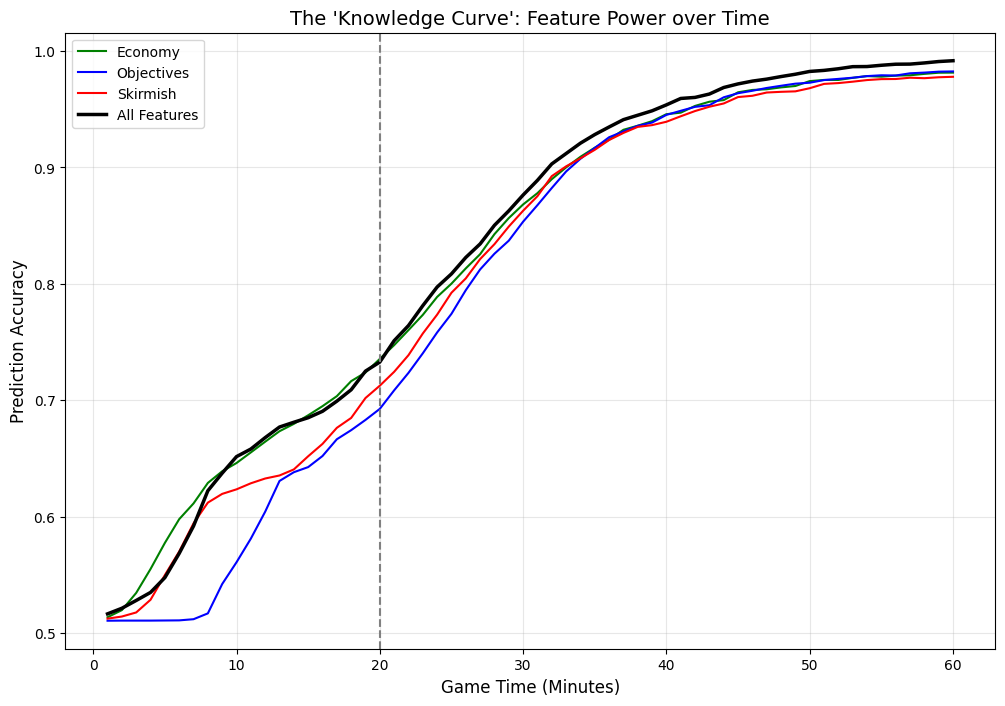

In [8]:
#LSTM Feature Comparison
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

if os.path.exists("dota2_time_series_full.csv"):
    FILE = "dota2_time_series_full.csv"
elif os.path.exists("dota2_time_series.csv"):
    FILE = "dota2_time_series.csv"
else:
    raise FileNotFoundError("Dataset not found!")

print(f"Loading {FILE}...")
df = pd.read_csv(FILE)

def parse_list(val):
    if isinstance(val, list): return val
    if isinstance(val, str):
        if 'nan' in val: return []
        try: return json.loads(val.replace("'", '"'))
        except:
            try: return ast.literal_eval(val)
            except: return []
    return []

MAX_LEN = 60
sequences = []
targets = []

PAD_VAL = -99.0

print("Building Tensor...")

for idx, row in df.iterrows():
    if pd.isna(row['radiant_win']): continue

    gold = parse_list(row.get('gold_t'))
    if not gold: continue

    length = min(len(gold), MAX_LEN)
    mat = np.full((length, 14), 0.0, dtype=np.float32) # Init with 0s

    def assign(col, data, scale):
        if not data: return
        d_len = min(len(data), length)
        if d_len > 0:
            arr = np.array(data[:d_len], dtype=np.float32)
            mat[:d_len, col] = np.clip(arr / scale, -5.0, 5.0)

    # Economy
    assign(0, gold, 20000.0)
    assign(1, parse_list(row.get('xp_t')), 20000.0)
    # Objectives
    assign(2, parse_list(row.get('r_tow_t')), 11.0)
    assign(3, parse_list(row.get('d_tow_t')), 11.0)
    assign(4, parse_list(row.get('r_rax_t')), 6.0)
    assign(5, parse_list(row.get('d_rax_t')), 6.0)
    assign(6, parse_list(row.get('r_rosh_t')), 5.0)
    assign(7, parse_list(row.get('d_rosh_t')), 5.0)
    # Skirmish
    assign(8, parse_list(row.get('r_kills_t')), 60.0)
    assign(9, parse_list(row.get('d_kills_t')), 60.0)
    assign(10, parse_list(row.get('r_tf_t')), 15.0)
    assign(11, parse_list(row.get('d_tf_t')), 15.0)
    # Farming
    assign(12, parse_list(row.get('r_lh_t')), 2000.0)
    assign(13, parse_list(row.get('d_lh_t')), 2000.0)

    sequences.append(mat)
    targets.append(row['radiant_win'])

X_master = pad_sequences(sequences, maxlen=MAX_LEN, dtype='float32', padding='post', value=PAD_VAL)
y_master = np.array(targets).astype('float32')

X_master = np.nan_to_num(X_master, nan=0.0)
print(f"Tensor Ready. Shape: {X_master.shape}")

feature_groups = {
    "Economy": [0, 1, 12, 13],
    "Objectives": [2, 3, 4, 5, 6, 7],
    "Skirmish": [8, 9, 10, 11],
    "All Features": list(range(14))
}

results = {}

for group_name, indices in feature_groups.items():
    print(f"\nTraining {group_name} LSTM...")

    X_sub = X_master[:, :, indices]
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_master, test_size=0.2, random_state=42)

    model = Sequential([
        Input(shape=(MAX_LEN, len(indices))),
        Masking(mask_value=PAD_VAL),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    try:
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=64, verbose=0)
    except Exception as e:
        print(f"Error training {group_name}: {e}")
        continue

    accs = []
    minutes = list(range(1, MAX_LEN + 1))

    for m in minutes:
        X_trunc = X_test.copy()
        if m < MAX_LEN:
            X_trunc[:, m:, :] = PAD_VAL

        preds = (model.predict(X_trunc, verbose=0) > 0.5).astype(int)
        accs.append(accuracy_score(y_test, preds))

    results[group_name] = accs
    print(f"  -> Min 10: {accs[9]:.2%} | Min 20: {accs[19]:.2%} | Min 30: {accs[29]:.2%}")

plt.figure(figsize=(12, 8))
colors = {'Economy': 'green', 'Objectives': 'blue', 'Skirmish': 'red', 'All Features': 'black'}

for name, accs in results.items():
    plt.plot(minutes, accs, label=name, linewidth=2.5 if name == 'All Features' else 1.5, color=colors.get(name, 'gray'))

plt.title("The 'Knowledge Curve': Feature Power over Time", fontsize=14)
plt.xlabel("Game Time (Minutes)", fontsize=12)
plt.ylabel("Prediction Accuracy", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(20, color='gray', linestyle='--', label="20 Min Mark")
plt.show()